# SBS SMK Test

This notebook should be used as a test for ensuring correct SBS image loading and processing before running a snakemake workflow.
Change the parameters specified at SET PARAMETERS cells and run the notebook to ensure the functions work as intended.

## Imports

In [1]:
from pathlib import Path

from ops.sbs_smk import Snake_sbs

import ops
from ops.imports_ipython import *
from ops.qc import *
import seaborn as sns
from microfilm import microplot
from microfilm.microplot import Micropanel
import matplotlib.pyplot as plt
import matplotlib

## SET PARAMETERS

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

### Loading, aligning, detecting candiate reads

- `SBS_CYCLES`: The number and order of SBS cycles
- `WELLS` and `TILES`: The well and tile you want to analyze (for this notebook, we're using one well/tile combination for testing)
- `CHANNELS` and `preprocess_pattern`: The channel names and file naming conventions
- `DISPLAY_RANGES` and `LUTS`: The display ranges and color schemes (Look-Up Tables) for your image data

### Illumination correction and segmentation

- `SEGMENTATION_CYCLE`: Determines which cycle is used for segmentation and illumination correction. Typically, this is set to the cycle with the brightest or clearest signal for cell boundaries, but in the case that we have just taken one multichannel image, it is set to that.
- `DAPI_INDEX`: The index of the DAPI channel in your image stack (0-indexed). Typically 0 for the DAPI channel from sequencing.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your image stack (0-indexed). Typically the channel that best outlines cell boundaries, usually base C.
- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

For Cellpose segmentation, we strongly suggest calibrating via the Cellpose GUI. Follow these steps:

1. Open a terminal window
2. SSH onto fry: `ssh -Y username@fry.wi.mit.edu`
3. Activate a conda environment with cellpose[gui]: `conda activate ops_viewing`
4. Launch Cellpose: `python -m cellpose`
5. Open the prepared Cellpose image: `sbs_1/tif/10X_well_Tile-nn.prepared_cellpose.tif`
6. Calibrate cyto3 model:
   - For cell diameter: use chan to segment = 2, chan2 = 3
   - For nuclei diameter: use chan to segment = 3, chan2 = 0

Note: You may want to adjust the diameter parameters and segment to test if you feel like you are capturing too little or too much area for either of the two masks.

### Extract base intensity, call reads, assign to cells

- `DF_DESIGN_PATH`: The path to your guide RNA design file
- `THRESHOLD_READS`: The intensity threshold for detecting sequencing reads. Adjust this value based on the signal-to-noise ratio in your data.
- `BASES`: The order of bases used in your sequencing. This should match the order of channels in your sequencing data.
The following cell contains an important parameter for filtering sequencing reads based on their quality. Please review and adjust this variable based on your specific experimental needs before proceeding with the analysis.
- `Q_MIN`: The minimum Levenshtein distance allowed between a read and its closest barcode match. A value of 0 means only perfect matches are accepted, while higher values allow for more mismatches. A lower value increases stringency but may reduce the number of accepted reads, while a higher value allows for more reads but may increase false positives.

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [2]:
# Output directory for notebook results
INPUT_FILES_DIR = "input/"
OUTPUT_FILES_DIR = "output/"

# Define lists of cycles
SBS_CYCLES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
CYCLE_FILES = None

# Set wells and tiles (in this notebook, one well / tile combination to test on)
WELLS = "A1"
TILES = 50
WILDCARDS = dict(well=WELLS, tile=TILES)

# Define channels
CHANNELS = None

# Define the file pattern
PREPROCESS_PATTERN = "10X_c{cycle}-SBS-{cycle}_{well}_Tile-{tile}.sbs.tif"

# Define display ranges for different channels, recognized by ImageJ
DISPLAY_RANGES = [
    [500, 15000],  # Range for DAPI channel
    [100, 10000],  # Range for CY3 channel
    [100, 10000],  # Range for A594 channel
    [200, 25000],  # Range for CY5 channel
    [200, 25000],  # Range for CY7 channel
]

# Define LUTs (Lookup Tables) for different channels
LUTS = [
    ops.io.GRAY,  # Lookup table for DAPI channel
    ops.io.GREEN,  # Lookup table for CY3 channel
    ops.io.RED,  # Lookup table for A594 channel
    ops.io.MAGENTA,  # Lookup table for CY5 channel
    ops.io.CYAN,  # Lookup table for CY7 channel
]

# Define cycle to use for segmentation, -1 for last cycle
SEGMENTATION_CYCLE = -1

# Define illumination correction file for use in segmentation
ICF_FILE_PATH = "input/10X_c11-SBS-11_A1.sbs.illumination_correction.tif"

# Define Cellpose segmentation parameters
DAPI_INDEX = 0
CYTO_CHANNEL = 4

# Parameters for cellpose method
NUCLEI_DIAMETER = 13.2  # Calibrate with CellPose
CELL_DIAMETER = 19.5  # Calibrate with CellPose
CYTO_MODEL = "cyto3"

# Define parameters for extracting bases
DF_DESIGN_PATH = "input/pool10_design.csv"
THRESHOLD_READS = 315
BASES = "GTAC"

# Define parameters for read mapping
Q_MIN = 0

In [3]:
# Function to generate file paths
def generate_file_paths(input_files_dir, preprocess_pattern, well, tile, sbs_cycles):
    file_paths = []

    # All cycles (all channels)
    for cycle in sbs_cycles:
        cycle_file_name = preprocess_pattern.format(
            cycle=cycle, well=well, tile=tile)
        cycle_file_path = f"{input_files_dir}{cycle_file_name}"
        file_paths.append(cycle_file_path)

    return file_paths

# Custom function to create segmentation colormap


def random_cmap(alpha=0.5, num_colors=256):
    """Create random colormap for segmentation"""
    colmat = np.random.rand(num_colors, 4)
    colmat[:, -1] = alpha
    # Set the first color to black with full transparency
    colmat[0, :] = [0, 0, 0, 1]
    cmap = matplotlib.colors.ListedColormap(colmat)
    return cmap

In [4]:
print("Loading input images...")
input_image_paths = generate_file_paths(
    INPUT_FILES_DIR, PREPROCESS_PATTERN, WELLS, TILES, SBS_CYCLES
)
input_images = [read(f) for f in input_image_paths]
print(f"Input images loaded: {len(input_images)}")
# parse description from input image
description = parse(input_image_paths[0])
keys_to_remove = ["cycle", "tag", "file"]
for key in keys_to_remove:
    description.pop(key, None)
print(f"Input file description: {description}")

Loading input images...
Input images loaded: 11
Input file description: {'subdir': 'input', 'mag': '10X', 'well': 'A1', 'tile': '50', 'ext': 'tif'}


Aligning input images...
Shape of SBS images aligned across cycles: (11, 5, 1200, 1200)
Example aligned image for first cycle:


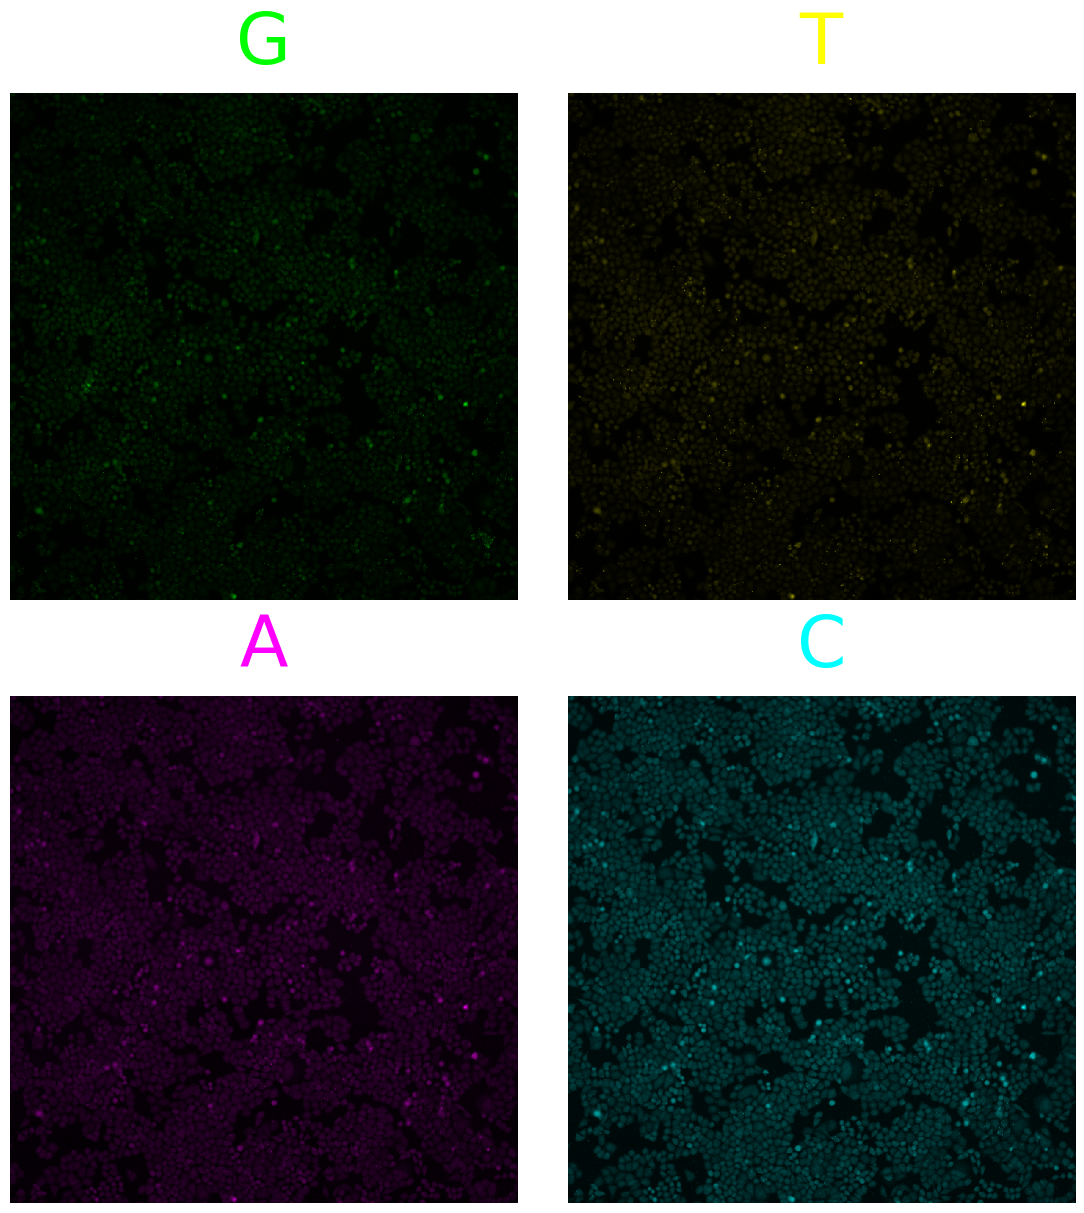

In [5]:
print("Aligning input images...")
# This corresponds to the 'align' rule in Snakemake
aligned = Snake_sbs._align_SBS(
    input_images,
    method="SBS_mean",
    cycle_files=CYCLE_FILES,
    upsample_factor=1,
    n=1,
    keep_extras=False,
)
save(
    name(description, tag="aligned", subdir=OUTPUT_FILES_DIR),
    aligned,
    display_ranges=DISPLAY_RANGES,
    luts=LUTS,
)
# expected dimensions of (CYCLE, CHANNEL, I, J)
print(f"Shape of SBS images aligned across cycles: {aligned.shape}")

print("Example aligned image for first cycle:")
# show aligned for one round
g_aligned_microshow = microplot.Microimage(
    aligned[0, 1, :, :], cmaps="pure_green", channel_names="G"
)
t_aligned_microshow = microplot.Microimage(
    aligned[0, 2, :, :], cmaps="pure_yellow", channel_names="T"
)
a_aligned_microshow = microplot.Microimage(
    aligned[0, 3, :, :], cmaps="pure_magenta", channel_names="A"
)
c_aligned_microshow = microplot.Microimage(
    aligned[0, 4, :, :], cmaps="pure_cyan", channel_names="C"
)
panel = Micropanel(rows=2, cols=2, figscaling=6)
panel.add_element([0, 0], g_aligned_microshow)
panel.add_element([0, 1], t_aligned_microshow)
panel.add_element([1, 0], a_aligned_microshow)
panel.add_element([1, 1], c_aligned_microshow)
panel.add_channel_label()

Detecting candidate reads...
Applying Laplacian-of-Gaussian (LoG) filter...


Computing standard deviation over cycles...
Applying max filter...
Finding peaks...
Example max filtered image for first cycle:


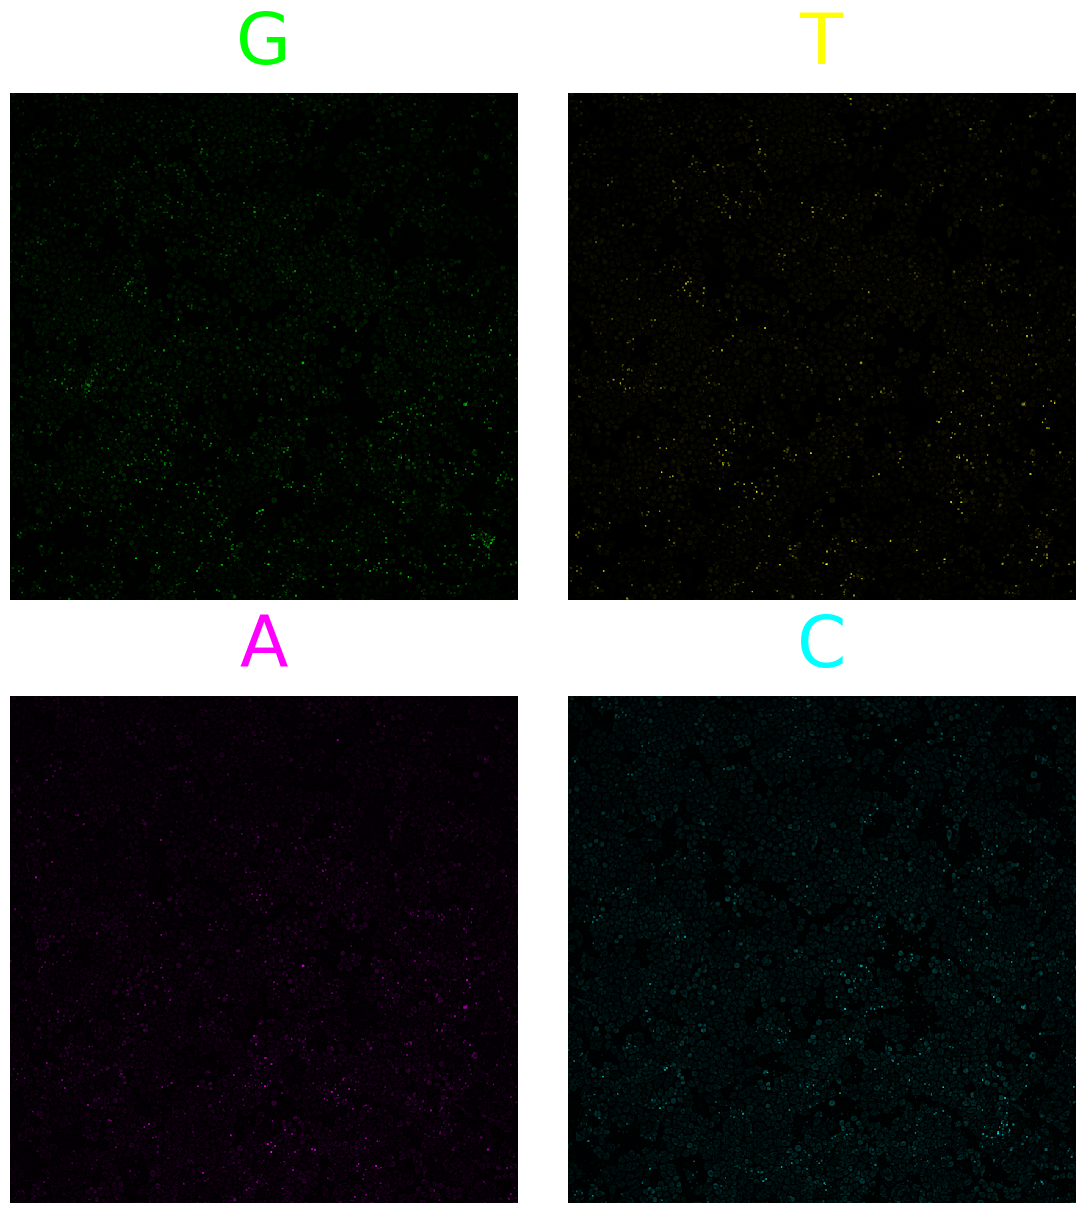

In [6]:
print("Detecting candidate reads...")

print("Applying Laplacian-of-Gaussian (LoG) filter...")
loged = Snake_sbs._transform_log(aligned, skip_index=0)
save(name(description, tag='log', subdir=OUTPUT_FILES_DIR),
     loged, display_ranges=DISPLAY_RANGES, luts=LUTS)

print("Computing standard deviation over cycles...")
std = Snake_sbs._compute_std(loged, remove_index=0)
save(name(description, tag='std', subdir=OUTPUT_FILES_DIR), std)

print("Applying max filter...")
# This corresponds to the 'max_filter' rule in Snakemake
maxed = Snake_sbs._max_filter(loged, width=3, remove_index=0)
save(name(description, tag='maxed', subdir=OUTPUT_FILES_DIR),
     maxed, display_ranges=DISPLAY_RANGES[1:], luts=LUTS[1:])

print("Finding peaks...")
peaks = Snake_sbs._find_peaks(std)
save(name(description, tag='peaks', subdir=OUTPUT_FILES_DIR), peaks)

print("Example max filtered image for first cycle:")
# show max filtered data for one round
g_maxed_microshow = microplot.Microimage(maxed[0, 0, :, :],
                                         cmaps='pure_green',
                                         channel_names='G')
t_maxed_microshow = microplot.Microimage(maxed[0, 1, :, :],
                                         cmaps='pure_yellow',
                                         channel_names='T')
a_maxed_microshow = microplot.Microimage(maxed[0, 2, :, :],
                                         cmaps='pure_magenta',
                                         channel_names='A')
c_maxed_microshow = microplot.Microimage(maxed[0, 3, :, :],
                                         cmaps='pure_cyan',
                                         channel_names='C')
panel = Micropanel(rows=2, cols=2, figscaling=6)
panel.add_element([0, 0], g_maxed_microshow)
panel.add_element([0, 1], t_maxed_microshow)
panel.add_element([1, 0], a_maxed_microshow)
panel.add_element([1, 1], c_maxed_microshow)
panel.add_channel_label()

In [7]:
print("Applying illumination correction to segmentation cycle image...")
# Read the illumination correction file
correction_image = read(ICF_FILE_PATH)
ic_segmentation_image = Snake_sbs._apply_illumination_correction(
    aligned[SEGMENTATION_CYCLE], correction=correction_image)
save(name(description, tag='illumination_correction', subdir=OUTPUT_FILES_DIR),
     ic_segmentation_image, display_ranges=DISPLAY_RANGES, luts=LUTS)

print("Preparing IC segmentation image for CellPose...")
cellpose_rgb = Snake_sbs._prepare_cellpose(
    ic_segmentation_image, DAPI_INDEX, CYTO_CHANNEL)
save(name(description, tag='prepared_cellpose',
     subdir=OUTPUT_FILES_DIR), cellpose_rgb)
# note, this process is done during the _segment_cellpose method below as well

print("Segmenting IC segmentation image with CellPose...")
nuclei, cells = Snake_sbs._segment_cellpose(
    ic_segmentation_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_CHANNEL,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cyto_model=CYTO_MODEL
)
save(name(description, tag='nuclei', subdir=OUTPUT_FILES_DIR), nuclei, compress=1)
save(name(description, tag='cells', subdir=OUTPUT_FILES_DIR), cells, compress=1)

print("Example microplots for DAPI channel and nuclei segmentation:")
dapi_microshow = microplot.Microimage(ic_segmentation_image[0, :, :],
                                      rescale_type='limits',
                                      limits=DISPLAY_RANGES[0],
                                      label_text='A',
                                      channel_names='Dapi')

nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(nuclei,
                                        label_text='B',
                                        cmaps=nuclei_cmap,
                                        channel_names='Nuclei')

panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], dapi_microshow)
panel.add_element([0, 1], nuclei_microshow)
panel.add_channel_label()
plt.show()

print("Example microplots for merged channels and cells segmentation:")
all_microshow = microplot.Microimage(ic_segmentation_image,
                                     label_text='A',
                                     rescale_type='limits',
                                     limits=DISPLAY_RANGES,
                                     channel_names='Merged')

cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells,
                                       label_text='B',
                                       cmaps=cells_cmap,
                                       channel_names='Cells')

panel = Micropanel(rows=1, cols=2, figscaling=10)
panel.add_element([0, 0], all_microshow)
panel.add_element([0, 1], cells_microshow)
panel.add_channel_label()
plt.show()

print("Annotating segmentation on sequencing data...")
annotated_data = Snake_sbs._annotate_segment_on_sequencing_data(
    aligned, nuclei, cells)
save(name(description, tag='segmentation', subdir=OUTPUT_FILES_DIR), annotated_data)

print("Example microplot for annotated segementation data:")
annotated_microshow = microplot.Microimage(
    annotated_data[0, :, :, :], label_text='A', channel_names='Merged')
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0, 0], annotated_microshow)
plt.show()

Applying illumination correction to segmentation cycle image...
Preparing IC segmentation image for CellPose...


/home/user/miniconda3/envs/sbs_dev/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


Segmenting IC segmentation image with CellPose...


100%|██████████| 25.3M/25.3M [00:00<00:00, 115MB/s]
100%|██████████| 3.54k/3.54k [00:00<00:00, 8.48MB/s]
100%|██████████| 25.3M/25.3M [00:00<00:00, 145MB/s]
100%|██████████| 5.23k/5.23k [00:00<00:00, 5.27MB/s]
found 3658 nuclei before removing edges
found 3608 cells before removing edges
found 3612 nuclei before reconciling
found 3524 cells before reconciling


removing edges
reconciling masks with method how=consensus


found 3473 nuclei/cells after reconciling


Number of nuclei segmented: 3473
Number of cells segmented: 3473
Example microplots for DAPI channel and nuclei segmentation:


NameError: name 'illumination_correction' is not defined

In [15]:
# Read and format guide data
df_design = pd.read_csv(DF_DESIGN_PATH)
df_pool = df_design.query("dialout==[0,1]").drop_duplicates("sgRNA")
df_pool["prefix"] = df_pool.apply(
    lambda x: x.sgRNA[: x.prefix_length], axis=1)  # 13
barcodes = df_pool["prefix"]

print("Extracting bases...")
bases_df = Snake_sbs._extract_bases(maxed, peaks, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES)
bases_df.to_csv(name(description, tag='bases', ext='csv', subdir=OUTPUT_FILES_DIR), index=None)
bases_df

# print("Base intensity across cycles:")
# ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=bases_df)
# plt.show()

# print("Intensity for each base:")
# ax = sns.boxplot(x="channel", y="intensity", hue="channel", data=bases_df, showfliers=False)
# plt.show()

print("Calling reads...")
reads_df = Snake_sbs._call_reads(bases_df, peaks=peaks)
reads_df.to_csv(name(description, tag='reads', ext='csv', subdir=OUTPUT_FILES_DIR), index=None)
reads_df

# print("Mapping rate vs. peak threshold for determining optimal peak cutoff:")
# plot_mapping_vs_threshold(reads_df, barcodes, "peak")
# plt.show()

# print("Mapping rate vs. Q_min for determining optimal sequence quality cutoff:")
# plot_mapping_vs_threshold(reads_df, barcodes, "Q_min")
# plt.show()

Extracting bases...


/home/user/OpticalPooledScreens/ops/in_situ.py:72: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = (df.stack([CYCLE, CHANNEL])


Calling reads...


,read,cell,i,j,tile,well,barcode,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,Q_min,peak
46,1,0,5,586,50,A1,AAGATGCCCAA,0.000000,1.0,1.00000,0.773706,1.0,0.870850,1.00000,1.0,1.0,1.000000,0.943358,0.000000,614.976478
574,13,0,9,1178,50,A1,GGCAAAGCGGG,0.738140,1.0,1.00000,1.000000,1.0,1.000000,1.00000,1.0,1.0,1.000000,0.738140,0.738140,322.375376
1234,28,0,17,174,50,A1,TTCAACAATCT,1.000000,1.0,0.60206,0.000000,1.0,0.415037,1.00000,1.0,1.0,0.276692,1.000000,0.000000,715.961129
1322,30,0,18,436,50,A1,AGCCGGCGAAG,0.000000,1.0,1.00000,1.000000,1.0,0.738140,0.73814,1.0,1.0,1.000000,0.738140,0.000000,342.279595
1674,38,0,21,189,50,A1,TTAAAGAAAGG,1.000000,1.0,1.00000,1.000000,1.0,1.000000,1.00000,1.0,1.0,1.000000,0.738140,0.738140,382.729685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151142,3435,3467,1181,255,50,A1,GAACACATAGC,0.415037,1.0,1.00000,1.000000,1.0,1.000000,1.00000,1.0,1.0,1.000000,0.738140,0.415037,417.057861
151978,3454,3467,1187,248,50,A1,GTTCTAAGAGC,0.634788,1.0,1.00000,1.000000,1.0,1.000000,1.00000,1.0,1.0,0.919047,1.000000,0.634788,727.592897
152374,3463,3467,1191,252,50,A1,ATTGTGTTGCA,1.000000,1.0,1.00000,1.000000,1.0,1.000000,1.00000,1.0,1.0,1.000000,1.000000,1.000000,533.428231
152022,3455,3469,1187,568,50,A1,TATCTCCAATA,0.738140,1.0,1.00000,0.634788,1.0,0.738140,0.73814,1.0,0.0,1.000000,0.000000,0.000000,331.248538


In [16]:
# Make alternate annotation tif images
print("Annotating bases on SBS LoG...")
annotated_bases=Snake_sbs._annotate_bases_on_SBS_log(loged, reads_df)
save(name(description, tag='annotated_bases', subdir=OUTPUT_FILES_DIR), annotated_bases)
print("Annotating bases on SBS read peaks (return reads)...")
annotated_reads=Snake_sbs._annotate_bases_on_SBS_reads_peaks(loged, peaks, reads_df, df_pool, SBS_CYCLES, shape=(1200, 1200), return_channels="reads")
save(name(description, tag='annotated_reads', subdir=OUTPUT_FILES_DIR), annotated_reads)
print("Annotating bases on SBS read peaks (return peaks)...")
annotated_peaks=Snake_sbs._annotate_bases_on_SBS_reads_peaks(loged, peaks, reads_df, df_pool, SBS_CYCLES, shape=(1200, 1200), return_channels="peaks")
save(name(description, tag='annotated_peaks', subdir=OUTPUT_FILES_DIR), annotated_peaks)

Annotating bases on SBS LoG...


/home/user/OpticalPooledScreens/ops/annotate.py:169: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(bases.index)


Annotating bases on SBS read peaks (return reads)...


/home/user/OpticalPooledScreens/ops/annotate.py:169: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(bases.index)


ValueError: All elements of footprint sequence must be a 2-tuple where the first element of the tuple is an ndarray and the second is an integer indicating the number of iterations.